# Deep learning 02456 - Project report

## Title: Integration of Genomic and Clinical Datasets to Cluster Patients using a Variational Autoencoder Framework
### Authors: Rosa Lundbye Allesøe, Tugce Karaderi, Caroline Brorsson



The aim of this notebook is to use a VAE framework to cluster patients into clinically relevant subgroups using integrated patient data, including continuous-, categorical, and genetic variables.

### Steps included in the pipeline:

- Encode the input data into numpy files
- Initiate variables
- Train model
- Evaluate losses and reconstruction accuracy 
- Run clustering and dimensionality reduction using UMAP
- Plot variables on top of UMAP and evaluate data structure and clustering results
- Run clustering and UMAP visualisation on raw data for comparison



In [1]:
#!/usr/bin/env python

import os, sys
import torch
import numpy as np
from torch.utils import data
import re 

from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import umap
from scipy.stats.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import random
import copy
import scipy
from scipy import stats
plt.style.use('seaborn-whitegrid')

path = "/Users/caroline/Documents/DTU_Projects/Courses/Deep_learning_HT2019/project/"
sys.path.append(path + "scripts/")


Load the VAE function, encode data and plotting functions

In [2]:
import intVAE_v1_0
from encode_data import encode_cat, encode_con
from plotting import embedding_plot_discrete, embedding_plot_float

Functions for reading in the data:

In [3]:
def read_cat(file):
   data = np.load(file)
   data = data.astype(np.float32)
   data_input = data.reshape(data.shape[0], -1)
   
   return data, data_input

def read_con(file):
   data = np.load(file)
   data = data.astype(np.float32)
   data[np.isnan(data)] = 0
   consum = data.sum(axis=0)
   mask_col = consum != 0
   data = data[:,mask_col]
   
   return data, mask_col

def read_header(file, mask=None):
   with open(file, "r") as f:
      h = list()
      for line in f:
         h.append(line.rstrip())
   
   if not mask is None:
      h = np.array(h)
      h = h[mask]
   
   return h

Encode the data from tab seperated text files and save as npy files (can be skipped if data is already encoded)

In [4]:
# define paths
path = "/Users/caroline/Documents/DTU_Projects/Courses/Deep_learning_HT2019/project/data/"

# categorical pheno data
file = path + "categorical_combined.tsv"
out = path + "input/categorical_combined.npy"
num_classes = 2
uniques = ["0", "1", "NA"]
data_input = encode_cat(file, num_classes, uniques)
np.save(out, data_input)

# continuous data
file = path + "clinical_combined.tsv"
out = path + "input/clinical_combined.npy"
data_input = encode_con(file)
np.save(out, data_input)

# genotype data
file = path + "genetics_combined.tsv"
out = path + "input/genetics_combined.npy"
num_classes = 3
uniques = ["0", "1", "2", "NA"]
data_input = encode_cat(file, num_classes, uniques)
np.save(out, data_input)


Read in data from npy files

In [5]:
path = "/Users/caroline/Documents/DTU_Projects/Courses/Deep_learning_HT2019/project/data/"

## load categorical pheno data 
cat_pheno, cat_pheno_input = read_cat(path + "input/categorical_combined.npy")

## load in continuous pheno data
con_pheno, con_mask = read_con(path + "input/clinical_combined.npy")

## load in genotype data
geno, geno_input = read_cat(path + "input/genetics_combined.npy")

Initiate variables:

In [6]:
## Initiate variables 
cuda = False
device = torch.device("cuda" if cuda == True else "cpu")

cat_list = [cat_pheno, geno]
con_list = [con_pheno]


nepochs=500
lrate=1e-3
kldsteps=[20, 30, 40]
batchsteps=[50, 70, 100, 150, 200, 250, 300, 350, 400, 450]

losses = list()
ce = list()
sse = list()
KLD = list()
kld_w = 0
l = len(kldsteps)
r = 20/l
update = 1 + r
epochs = range(1, nepochs + 1)
count = 0
l_min = 10000

Make data loader and choose batch size:

In [7]:
mask, train_loader = intVAE_v1_0.make_dataloader(cat_list=cat_list, con_list=con_list, batchsize=15) 

ncontinuous = train_loader.dataset.con_all.shape[1]
con_shapes = train_loader.dataset.con_shapes

ncategorical = train_loader.dataset.cat_all.shape[1]
cat_shapes = train_loader.dataset.cat_shapes


Make model and run analysis:

In [8]:
## Make model
model = intVAE_v1_0.VAE(ncategorical=ncategorical, ncontinuous=ncontinuous, con_shapes=con_shapes,
             cat_shapes=cat_shapes, nhiddens=[200], nlatent=20, beta=0.001, cat_weights=[1/2,1/2],
             con_weights=[1], dropout=0.1, cuda=cuda).to(device)

## Run analysis
for epoch in range(1, nepochs + 1):
    
    if epoch in kldsteps:
        kld_w = 1/20 * update
        update += r
    
        
    if epoch in batchsteps:
            train_loader = DataLoader(dataset=train_loader.dataset,
                                      batch_size=int(train_loader.batch_size * 1.25),
                                      shuffle=True,
                                      drop_last=True,
                                      num_workers=train_loader.num_workers,
                                      pin_memory=train_loader.pin_memory)
    
    l, c, s, k = model.enodeing(train_loader, epoch, lrate, kld_w)
    losses.append(l)
    ce.append(c)
    sse.append(s)
    KLD.append(k)
    


## Get latent representation
train_test_loader = DataLoader(dataset=train_loader.dataset, batch_size=1, drop_last=False,
                          shuffle=False, num_workers=1, pin_memory=train_loader.pin_memory)

latent, latent_var, cat_recon, cat_class, con_recon, loss, likelihood = model.latent(train_test_loader, kld_w)

con_recon = np.array(con_recon)
con_recon = torch.from_numpy(con_recon)

	Epoch: 1	Loss: 1.986187	CE: 0.9405780	SSE: 1.045609	KLD: 0.0000	Batchsize: 15
	Epoch: 2	Loss: 1.688282	CE: 0.9035540	SSE: 0.784728	KLD: 0.0000	Batchsize: 15
	Epoch: 3	Loss: 1.509182	CE: 0.8693021	SSE: 0.639880	KLD: 0.0000	Batchsize: 15
	Epoch: 4	Loss: 1.396354	CE: 0.8415204	SSE: 0.554834	KLD: 0.0000	Batchsize: 15
	Epoch: 5	Loss: 1.325386	CE: 0.8089572	SSE: 0.516429	KLD: 0.0000	Batchsize: 15
	Epoch: 6	Loss: 1.227540	CE: 0.7758113	SSE: 0.451729	KLD: 0.0000	Batchsize: 15
	Epoch: 7	Loss: 1.147718	CE: 0.7345638	SSE: 0.413154	KLD: 0.0000	Batchsize: 15
	Epoch: 8	Loss: 1.063140	CE: 0.7011054	SSE: 0.362035	KLD: 0.0000	Batchsize: 15
	Epoch: 9	Loss: 1.010451	CE: 0.6673465	SSE: 0.343105	KLD: 0.0000	Batchsize: 15
	Epoch: 10	Loss: 0.961714	CE: 0.6271071	SSE: 0.334607	KLD: 0.0000	Batchsize: 15
	Epoch: 11	Loss: 0.902274	CE: 0.5915576	SSE: 0.310717	KLD: 0.0000	Batchsize: 15
	Epoch: 12	Loss: 0.862794	CE: 0.5725608	SSE: 0.290234	KLD: 0.0000	Batchsize: 15
	Epoch: 13	Loss: 0.828234	CE: 0.5507642	SSE: 0.27

	Epoch: 104	Loss: 0.433959	CE: 0.2766976	SSE: 0.106250	KLD: 0.0510	Batchsize: 27
	Epoch: 105	Loss: 0.436385	CE: 0.2777559	SSE: 0.107609	KLD: 0.0510	Batchsize: 27
	Epoch: 106	Loss: 0.422245	CE: 0.2717388	SSE: 0.099605	KLD: 0.0509	Batchsize: 27
	Epoch: 107	Loss: 0.432603	CE: 0.2767277	SSE: 0.105302	KLD: 0.0506	Batchsize: 27
	Epoch: 108	Loss: 0.427535	CE: 0.2706152	SSE: 0.106833	KLD: 0.0501	Batchsize: 27
	Epoch: 109	Loss: 0.439362	CE: 0.2721055	SSE: 0.116952	KLD: 0.0503	Batchsize: 27
	Epoch: 110	Loss: 0.430935	CE: 0.2672497	SSE: 0.112702	KLD: 0.0510	Batchsize: 27
	Epoch: 111	Loss: 0.426423	CE: 0.2687504	SSE: 0.106421	KLD: 0.0513	Batchsize: 27
	Epoch: 112	Loss: 0.441084	CE: 0.2708416	SSE: 0.119194	KLD: 0.0510	Batchsize: 27
	Epoch: 113	Loss: 0.425238	CE: 0.2687768	SSE: 0.105686	KLD: 0.0508	Batchsize: 27
	Epoch: 114	Loss: 0.412851	CE: 0.2689169	SSE: 0.093550	KLD: 0.0504	Batchsize: 27
	Epoch: 115	Loss: 0.425983	CE: 0.2672552	SSE: 0.108866	KLD: 0.0499	Batchsize: 27
	Epoch: 116	Loss: 0.418134	C

	Epoch: 206	Loss: 0.343932	CE: 0.2128173	SSE: 0.080754	KLD: 0.0504	Batchsize: 41
	Epoch: 207	Loss: 0.353610	CE: 0.2167796	SSE: 0.086502	KLD: 0.0503	Batchsize: 41
	Epoch: 208	Loss: 0.337198	CE: 0.2105260	SSE: 0.076519	KLD: 0.0502	Batchsize: 41
	Epoch: 209	Loss: 0.348298	CE: 0.2167798	SSE: 0.081184	KLD: 0.0503	Batchsize: 41
	Epoch: 210	Loss: 0.356693	CE: 0.2153618	SSE: 0.090605	KLD: 0.0507	Batchsize: 41
	Epoch: 211	Loss: 0.347273	CE: 0.2106170	SSE: 0.086059	KLD: 0.0506	Batchsize: 41
	Epoch: 212	Loss: 0.350032	CE: 0.2129560	SSE: 0.086499	KLD: 0.0506	Batchsize: 41
	Epoch: 213	Loss: 0.352669	CE: 0.2164650	SSE: 0.085546	KLD: 0.0507	Batchsize: 41
	Epoch: 214	Loss: 0.349972	CE: 0.2093252	SSE: 0.090180	KLD: 0.0505	Batchsize: 41
	Epoch: 215	Loss: 0.349637	CE: 0.2072058	SSE: 0.091995	KLD: 0.0504	Batchsize: 41
	Epoch: 216	Loss: 0.341955	CE: 0.2085678	SSE: 0.082828	KLD: 0.0506	Batchsize: 41
	Epoch: 217	Loss: 0.354748	CE: 0.2104078	SSE: 0.094180	KLD: 0.0502	Batchsize: 41
	Epoch: 218	Loss: 0.341012	C

	Epoch: 308	Loss: 0.299526	CE: 0.1791109	SSE: 0.069393	KLD: 0.0510	Batchsize: 63
	Epoch: 309	Loss: 0.303065	CE: 0.1809833	SSE: 0.070982	KLD: 0.0511	Batchsize: 63
	Epoch: 310	Loss: 0.295370	CE: 0.1765795	SSE: 0.067504	KLD: 0.0513	Batchsize: 63
	Epoch: 311	Loss: 0.300486	CE: 0.1761517	SSE: 0.072941	KLD: 0.0514	Batchsize: 63
	Epoch: 312	Loss: 0.292935	CE: 0.1739539	SSE: 0.067745	KLD: 0.0512	Batchsize: 63
	Epoch: 313	Loss: 0.297260	CE: 0.1777804	SSE: 0.068382	KLD: 0.0511	Batchsize: 63
	Epoch: 314	Loss: 0.299083	CE: 0.1739135	SSE: 0.074151	KLD: 0.0510	Batchsize: 63
	Epoch: 315	Loss: 0.297657	CE: 0.1770607	SSE: 0.069578	KLD: 0.0510	Batchsize: 63
	Epoch: 316	Loss: 0.305417	CE: 0.1759500	SSE: 0.078278	KLD: 0.0512	Batchsize: 63
	Epoch: 317	Loss: 0.297575	CE: 0.1713909	SSE: 0.075231	KLD: 0.0510	Batchsize: 63
	Epoch: 318	Loss: 0.297468	CE: 0.1757122	SSE: 0.070809	KLD: 0.0509	Batchsize: 63
	Epoch: 319	Loss: 0.293648	CE: 0.1745712	SSE: 0.068001	KLD: 0.0511	Batchsize: 63
	Epoch: 320	Loss: 0.295296	C

	Epoch: 410	Loss: 0.261407	CE: 0.1504516	SSE: 0.059655	KLD: 0.0513	Batchsize: 97
	Epoch: 411	Loss: 0.265902	CE: 0.1492645	SSE: 0.064948	KLD: 0.0517	Batchsize: 97
	Epoch: 412	Loss: 0.259213	CE: 0.1449164	SSE: 0.062504	KLD: 0.0518	Batchsize: 97
	Epoch: 413	Loss: 0.256302	CE: 0.1443482	SSE: 0.060134	KLD: 0.0518	Batchsize: 97
	Epoch: 414	Loss: 0.249828	CE: 0.1418044	SSE: 0.056404	KLD: 0.0516	Batchsize: 97
	Epoch: 415	Loss: 0.275308	CE: 0.1532539	SSE: 0.070672	KLD: 0.0514	Batchsize: 97
	Epoch: 416	Loss: 0.249574	CE: 0.1399785	SSE: 0.058329	KLD: 0.0513	Batchsize: 97
	Epoch: 417	Loss: 0.268021	CE: 0.1488677	SSE: 0.067578	KLD: 0.0516	Batchsize: 97
	Epoch: 418	Loss: 0.254609	CE: 0.1435819	SSE: 0.059225	KLD: 0.0518	Batchsize: 97
	Epoch: 419	Loss: 0.256942	CE: 0.1439278	SSE: 0.061254	KLD: 0.0518	Batchsize: 97
	Epoch: 420	Loss: 0.258197	CE: 0.1442649	SSE: 0.062129	KLD: 0.0518	Batchsize: 97
	Epoch: 421	Loss: 0.259611	CE: 0.1444563	SSE: 0.063429	KLD: 0.0517	Batchsize: 97
	Epoch: 422	Loss: 0.269622	C

Save results and plot loss

/Users/caroline/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/caroline/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LeakyReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/caroline/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Softplus. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/caroline/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sigmoid. It won't be checked for correctness upon loading.
  "type " + obj.__nam

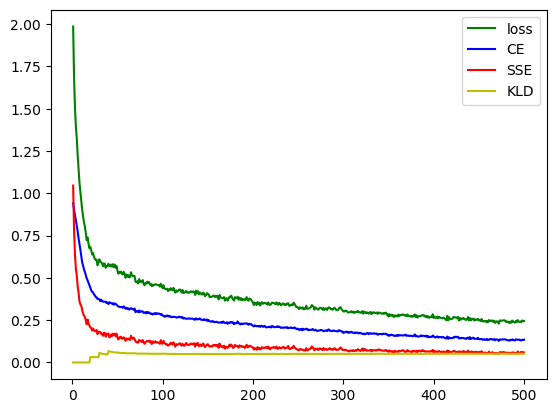

In [28]:
torch.save(model, path + "/output/train/model.pt")

np.save(path + "/output/train/mask.npy", mask)
np.save(path + "/output/train/latent.npy", latent)
np.save(path + "/output/train/con_recon.npy", con_recon)
np.save(path + "/output/train/cat_recon.npy", cat_recon)

fig = plt.figure()
plt.plot(epochs, losses, '-g', label='loss')
plt.plot(epochs, ce, '-b', label='CE')
plt.plot(epochs, sse, '-r', label='SSE')
plt.plot(epochs, KLD, '-y', label='KLD')
plt.legend()
#plt.savefig(path + "/output/evaluation/loss.png")
#plt.clf()

Evaluation of results - calculating accuracy

In [16]:
# Seperate in dataset if multiple categorical datasets
cat_acc_recon = []
pos = 0
for s in cat_shapes:
   n = s[1]
   cat_class_tmp = cat_class[:,pos:(n + pos)]
   cat_recon_tmp = cat_recon[:,pos:(n + pos)]
   
   # Worng class will bedifferent from 0
   diff_cat = cat_class_tmp - cat_recon_tmp
   true_cat = diff_cat[diff_cat == 0]
   false_cat = diff_cat[diff_cat != 0]
   
   # Calculate acc for each individual based on non-missing values 
   not_missing_counts = np.count_nonzero(cat_class_tmp != -1,axis=1)
   ntrue_vals = np.count_nonzero(diff_cat == 0, 1)
   accuracy = ntrue_vals[not_missing_counts != 0] / not_missing_counts[not_missing_counts != 0]
   cat_acc_recon.append(accuracy)
   pos += n


# Seperate in dataset if multiple continuous datasets
total_shape = 0
con_acc_recon = []
for s in con_shapes:
   cos_all = list()
   for n in range(0, con_recon.shape[0]):
        
      con_no_missing = train_loader.dataset.con_all[n,total_shape:(s + total_shape - 1)][train_loader.dataset.con_all[n,total_shape:(s + total_shape - 1)] != 0]
      if len(con_no_missing) <= 1:
         all_val.append(np.nan)
         continue
      con_out_no_missing = con_recon[n,total_shape:(s + total_shape - 1)][train_loader.dataset.con_all[n,total_shape:(s + total_shape - 1)] != 0]
      
      # Calcualte cosine similarity
      matrix = np.vstack([con_no_missing, con_out_no_missing])
      cos = cosine_similarity(matrix)[0,1]
      cos_all.append(cos)
   
   con_acc_recon.append(np.array(cos_all))
   total_shape += s

Plot reconstruction accuracy for each dataset:

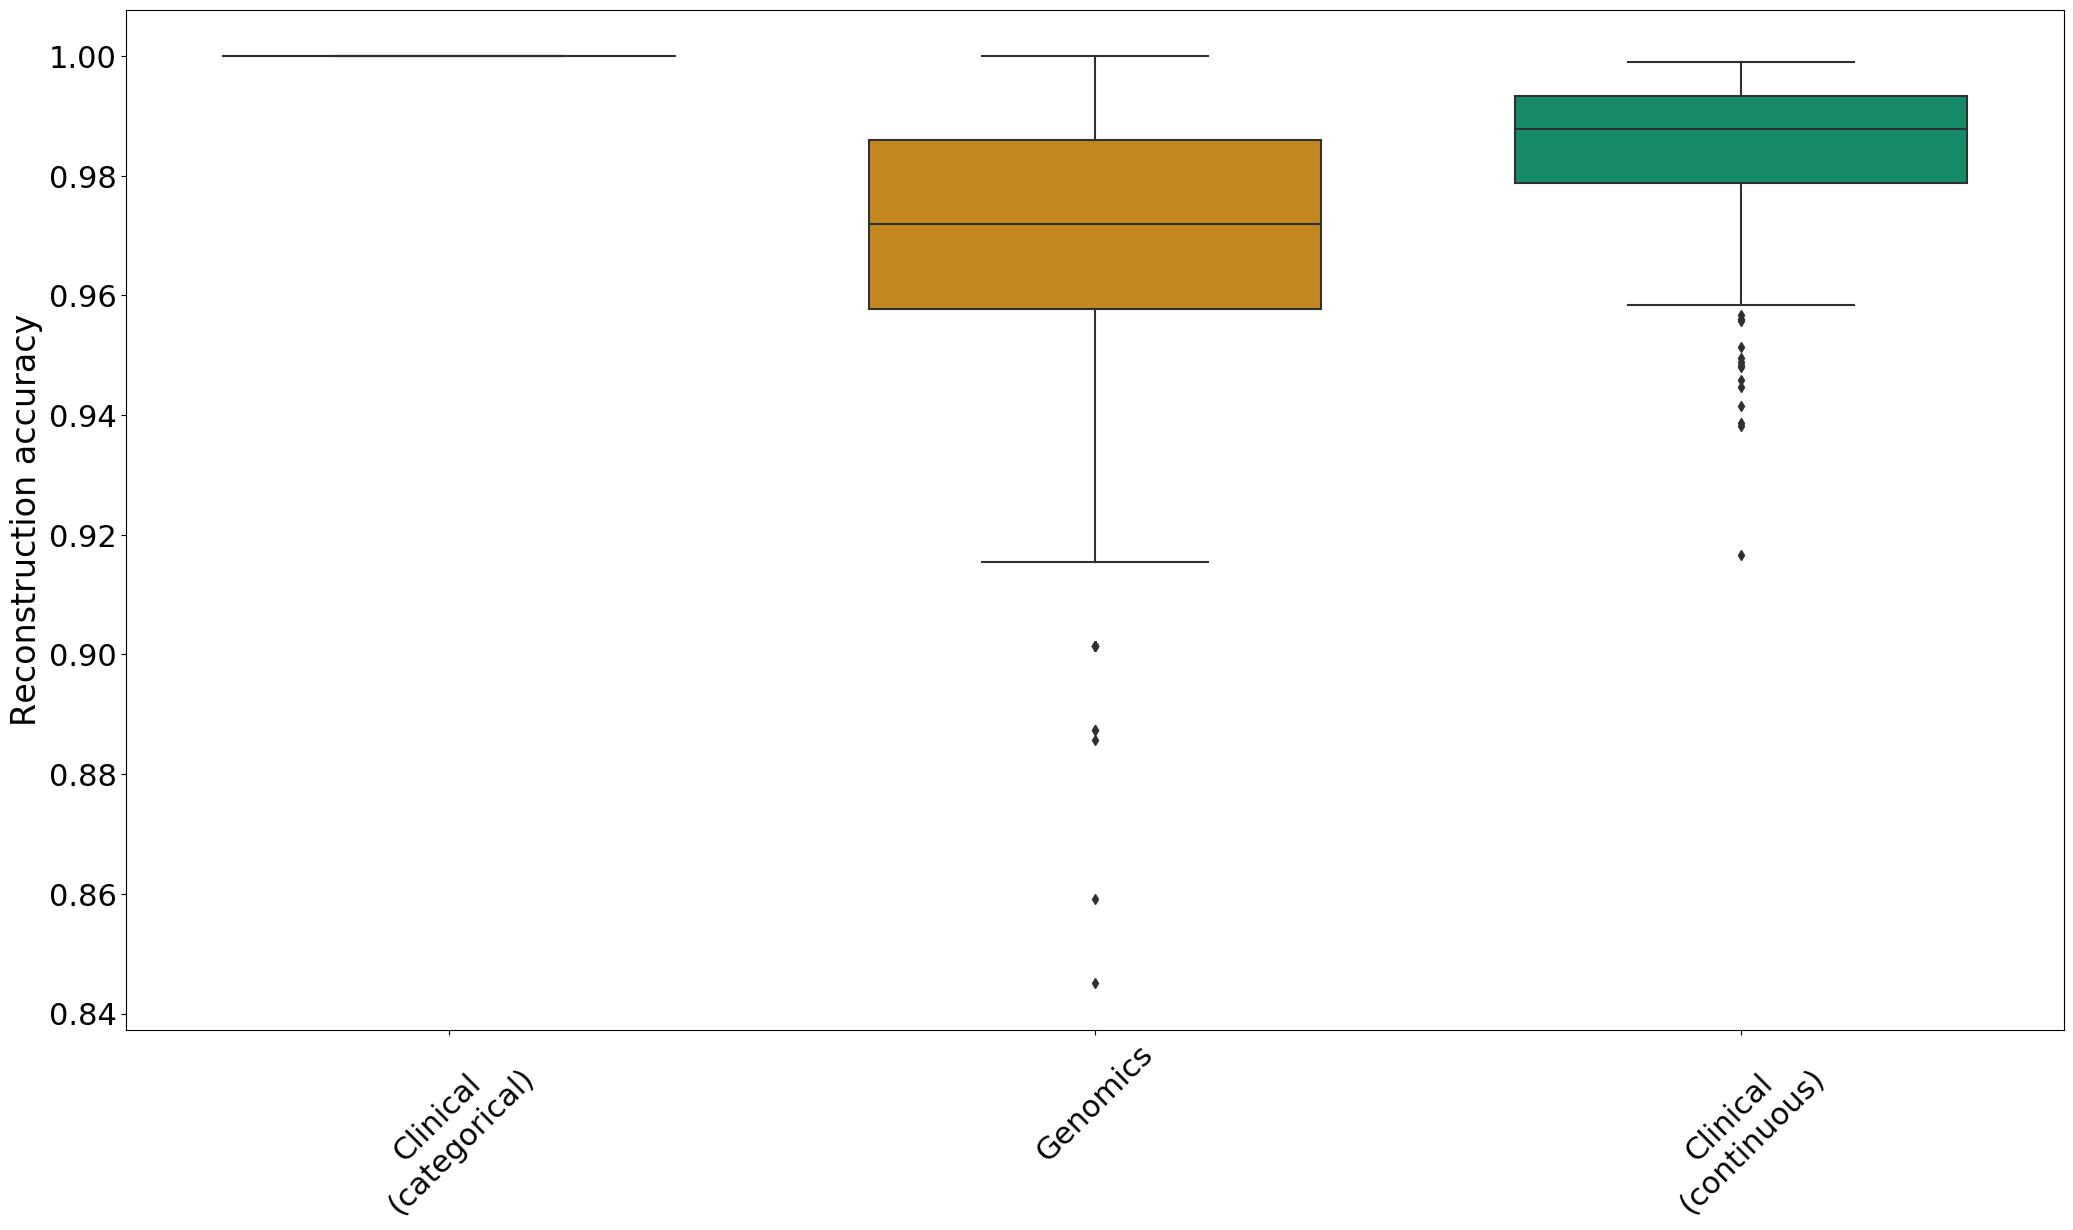

In [21]:
df = pd.DataFrame(cat_acc_recon + con_acc_recon, index = ['Clinical\n(categorical)', 'Genomics', 'Clinical\n(continuous)'])
df_t = df.T

fig = plt.figure(figsize=(25,15))
ax = sns.boxplot(data=df_t, palette="colorblind", width=0.7)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.ylabel('Reconstruction accuracy', fontsize=24)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)
fig.subplots_adjust(bottom=0.2)
#plt.savefig(path + "/output/evaluation/recon.png")
#plt.close("all")


Run clustering and UMAP:

In [18]:
# clustering
kmeans = KMeans(n_clusters=3)
# Fitting the input data
kmeans = kmeans.fit(latent)
# Getting the cluster labels
labels = kmeans.predict(latent)
labels = labels.astype(str)
# Centroid values
centroids = kmeans.cluster_centers_
np.save(path + "/output/clustering/labels.npy", labels)

# GM'spherical
gmm = GaussianMixture(n_components=3)
gmm.fit(latent)
gmm_result = gmm.predict(latent)
gmm_result = gmm_result.astype(str)

# UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(latent)
np.save(path + "/output/clustering/embedding.npy", embedding)


Plot the latent layer representation:

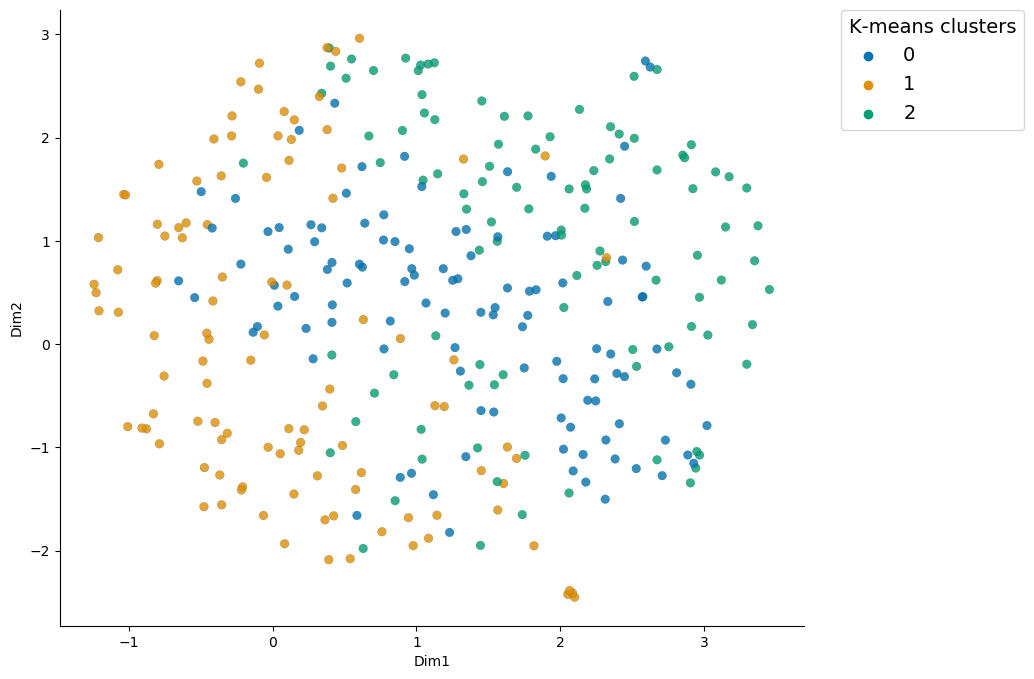

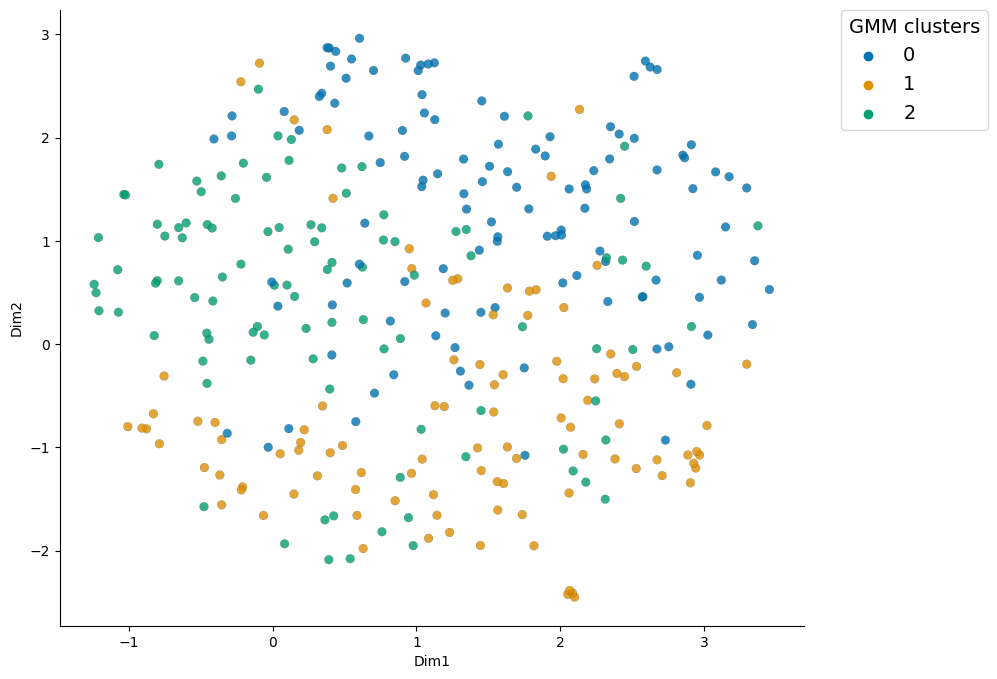

In [23]:
## clustering plots
embedding_plot_discrete(embedding, labels, "K-means clusters", path + "/output/clustering/umap_kmeans.png")
embedding_plot_discrete(embedding, gmm_result, "GMM clusters", path + "/output/clustering/umap_gmm.png")


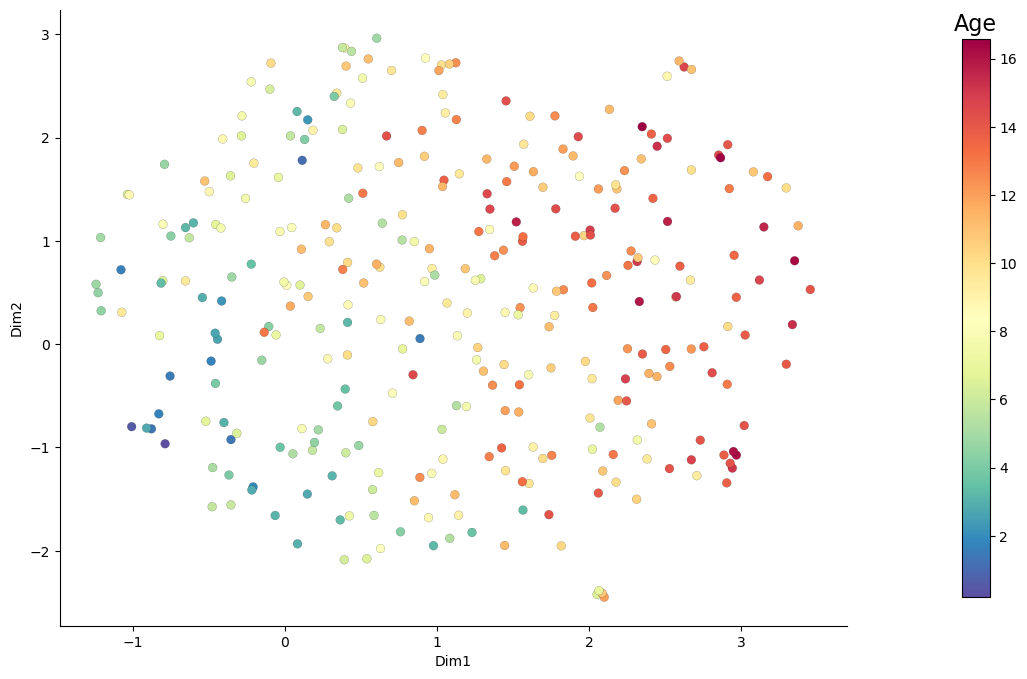

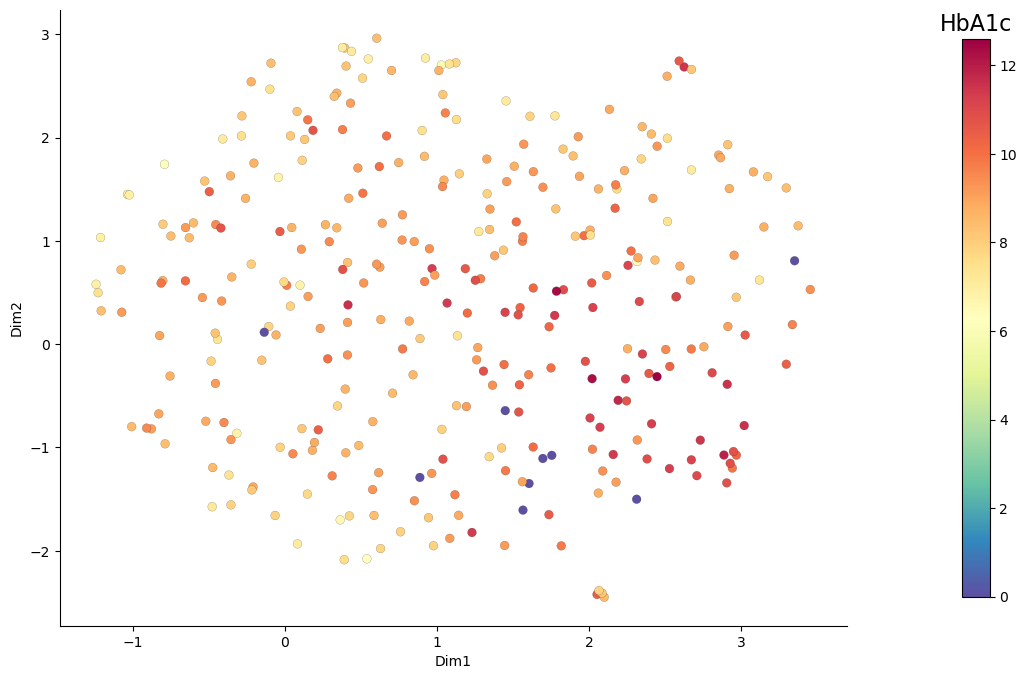

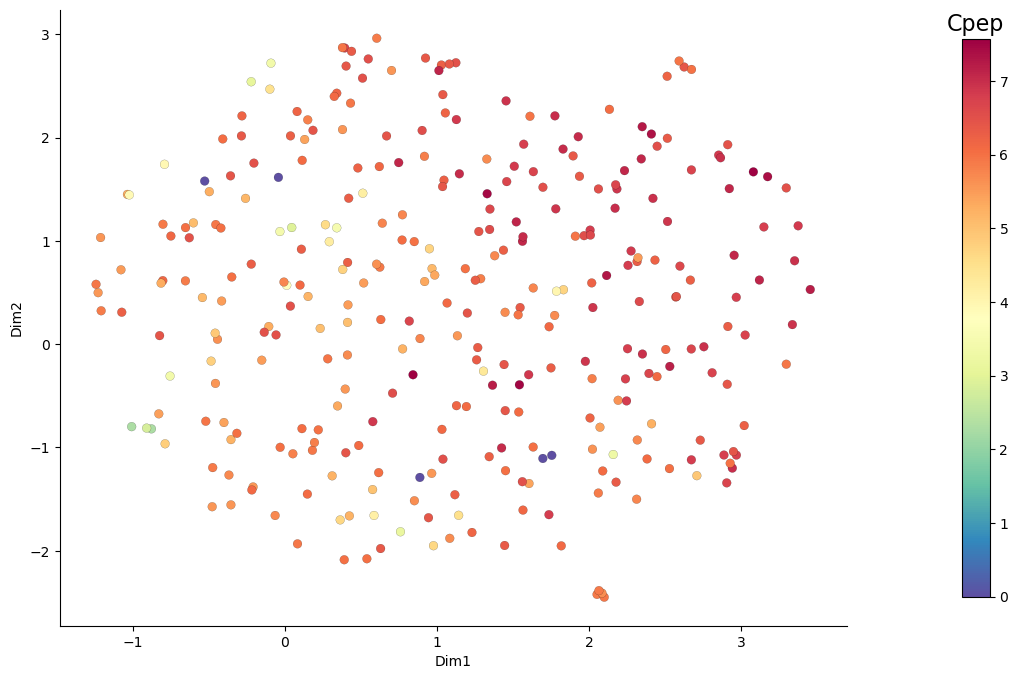

In [24]:
# plot continuous
raw_input = list()
with open("/Users/caroline/Documents/DTU_Projects/Courses/Deep_learning_HT2019/project/data/clinical_combined.tsv", "r") as f:
   header = f.readline()
   for line in f:
      line = line.rstrip()
      tmp = np.array(line.split("\t"))
      vals = tmp[1:]
      vals[vals == 'NA'] = 0
      vals = list(map(float, vals))
      raw_input.append(vals)

headers = header.split("\t")[1:]
con_vals = np.array(raw_input)

age = con_vals[:,headers.index( "age")]
HbA1c = con_vals[:,headers.index( "hba1c")]
Cpep = con_vals[:,headers.index("log_cpep")]

embedding_plot_float(embedding, age[mask], "Age", path + "/output/clustering/umap_age.png")
embedding_plot_float(embedding, HbA1c[mask], "HbA1c", path + "/output/clustering/umap_hba1c.png")
embedding_plot_float(embedding, Cpep[mask], "Cpep", path + "/output/clustering/umap_cpep.png")


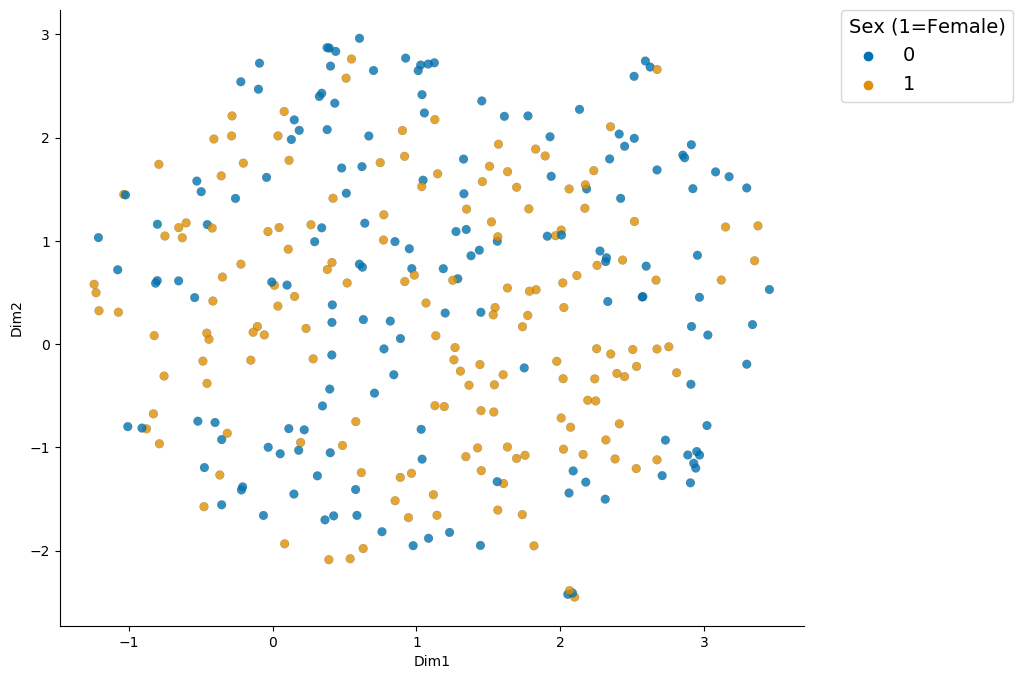

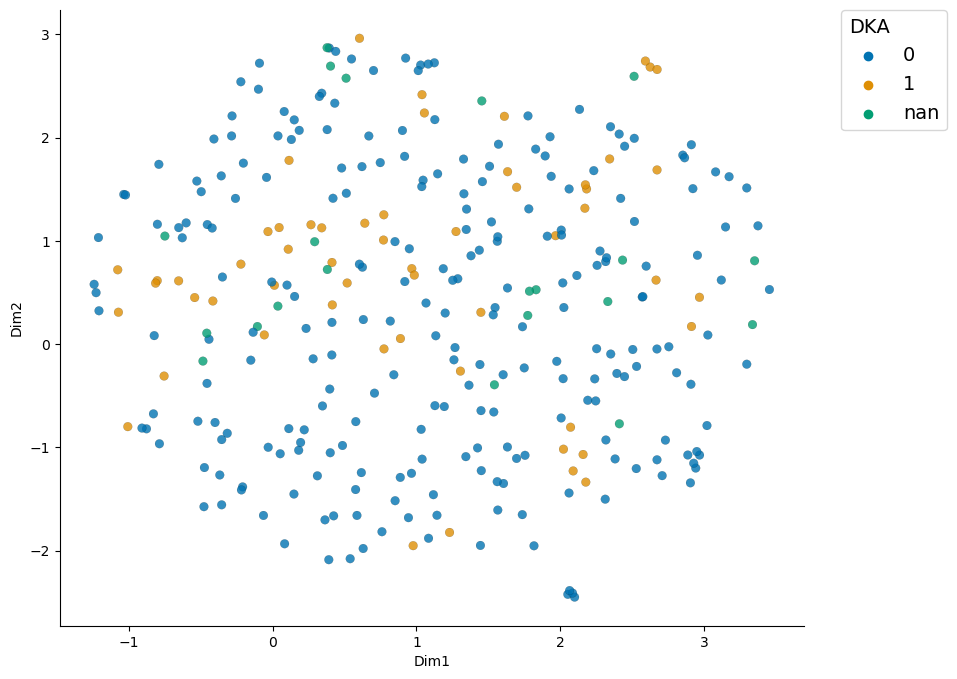

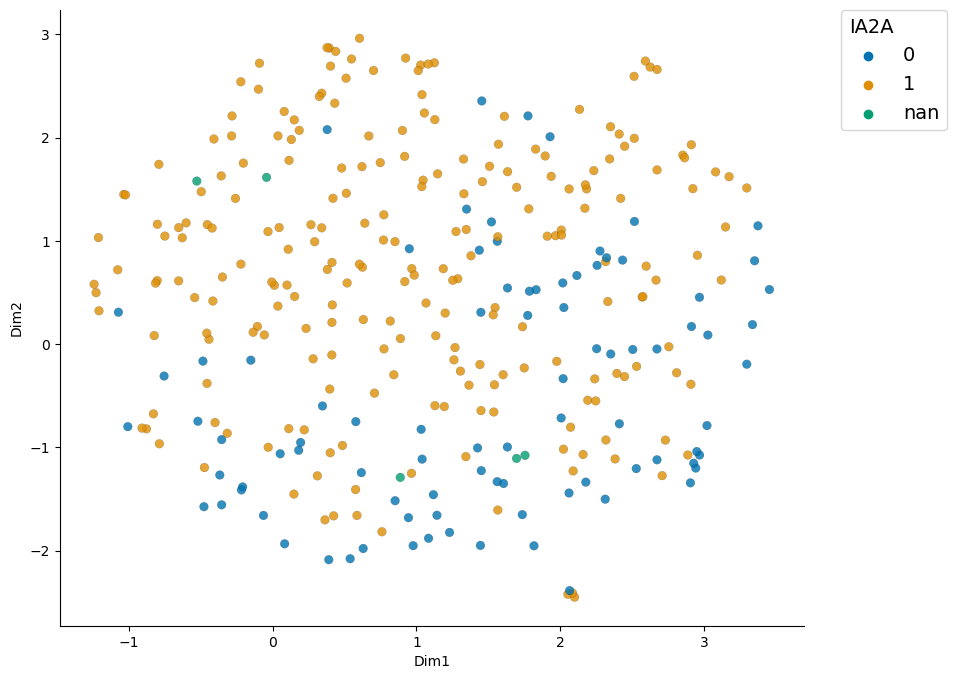

In [25]:
# plot categorical
cat_vals = list()
with open("/Users/caroline/Documents/DTU_Projects/Courses/Deep_learning_HT2019/project/data/categorical_combined.tsv", "r") as f:
   header = f.readline().rstrip()
   for line in f:
      line = line.rstrip()
      tmp = np.array(line.split("\t"))
      vals = tmp[1:]
      vals[vals == 'NA'] = np.nan
      cat_vals.append(vals)

headers_cat = header.split("\t")[1:]
cat_vals = np.array(cat_vals)

Sex = cat_vals[:,headers_cat.index("sex")]
DKA = cat_vals[:,headers_cat.index("dka")]
IA2A = cat_vals[:,headers_cat.index("ia2a")]

embedding_plot_discrete(embedding, Sex[mask], "Sex (1=Female)", path + "/output/clustering/umap_sex.png")
embedding_plot_discrete(embedding, DKA[mask], "DKA", path + "/output/clustering/umap_dka.png")
embedding_plot_discrete(embedding, IA2A[mask], "IA2A", path + "/output/clustering/umap_ia2a.png")


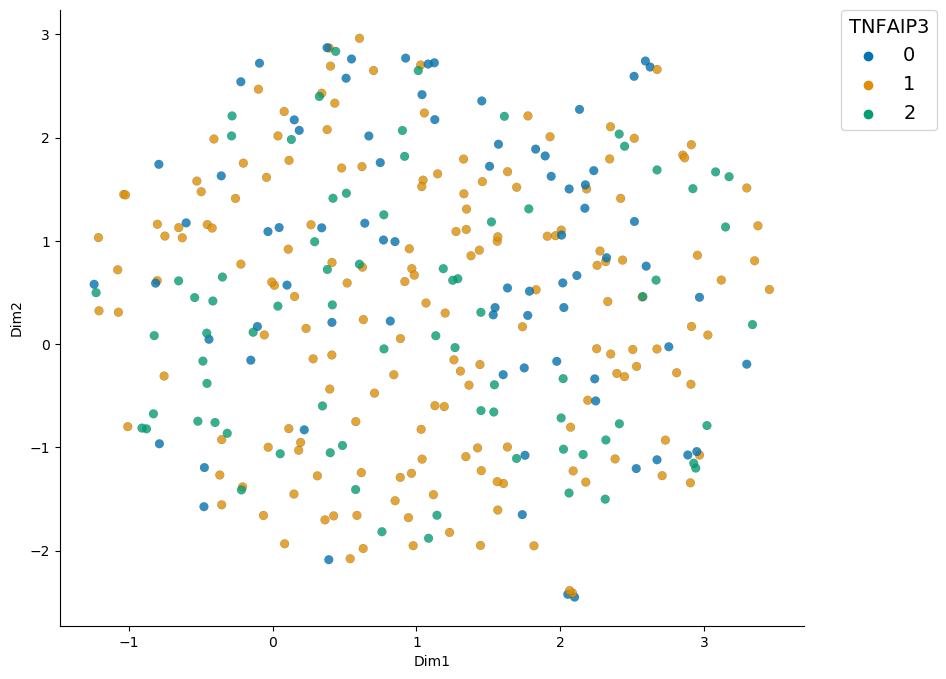

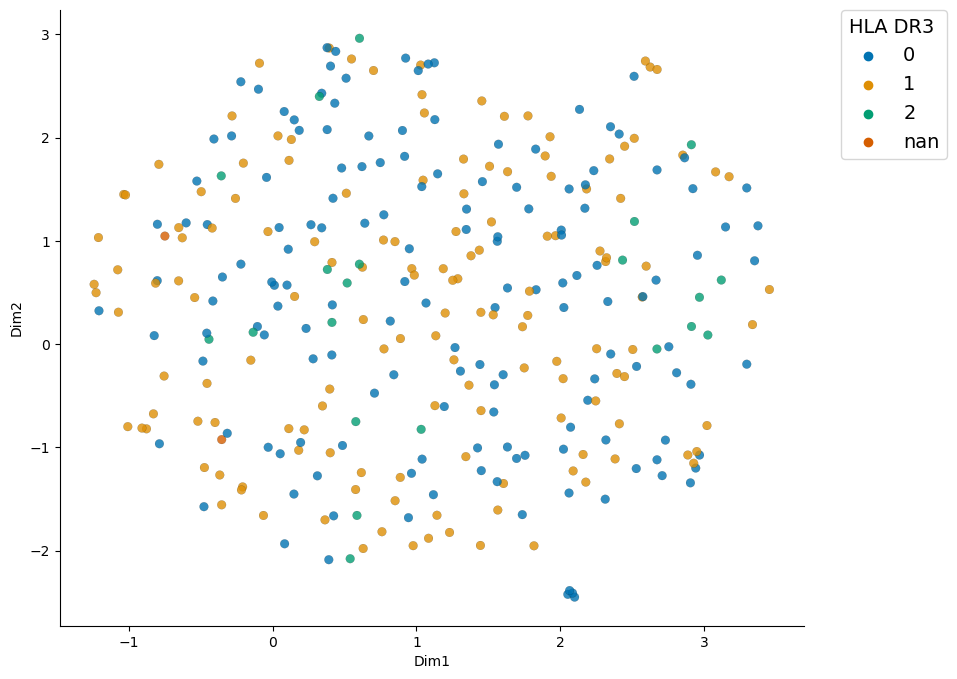

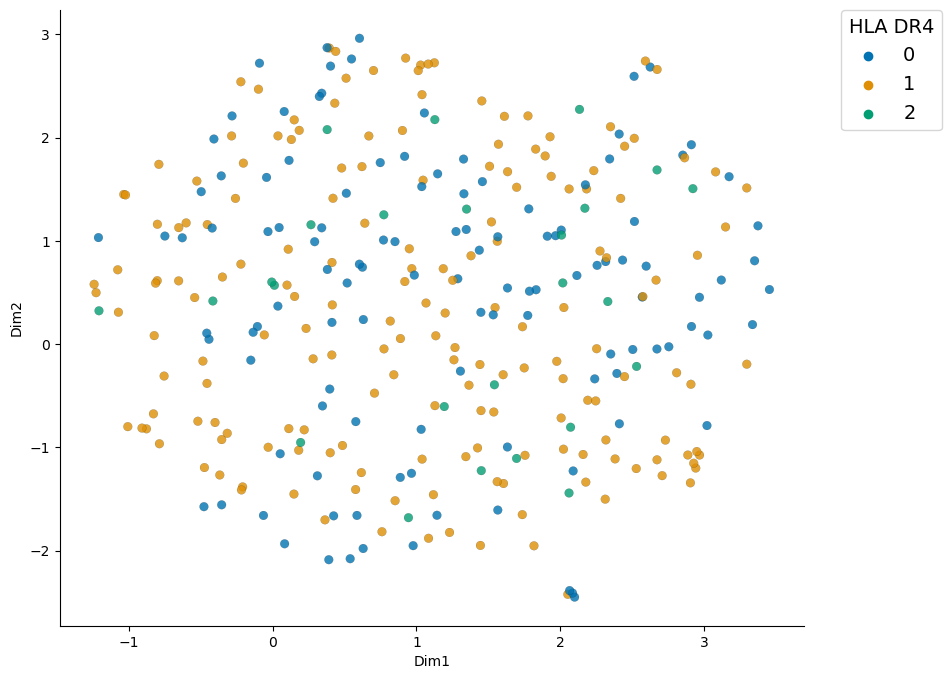

In [27]:
# plot genetic variants
gen_vals = list()
with open("/Users/caroline/Documents/DTU_Projects/Courses/Deep_learning_HT2019/project/data/genetics_combined.tsv", "r") as f:
   header = f.readline().rstrip()
   for line in f:
      line = line.rstrip()
      tmp = np.array(line.split("\t"))
      vals = tmp[1:]
      vals[vals == 'NA'] = np.nan
      gen_vals.append(vals)

headers_gen = header.split("\t")[1:]
gen_vals = np.array(gen_vals)

tnfaip3 = gen_vals[:,headers_gen.index("imm_6_137978089_G")]
HLA1 = gen_vals[:,headers_gen.index("rs2187668_A")]
HLA2 = gen_vals[:,headers_gen.index("rs7454108_G")]

embedding_plot_discrete(embedding, tnfaip3[mask], "TNFAIP3", path + "/output/clustering/umap_tnfaip3.png")
embedding_plot_discrete(embedding, HLA1[mask], "HLA DR3", path + "/output/clustering/umap_DR3.png")
embedding_plot_discrete(embedding, HLA2[mask], "HLA DR4", path + "/output/clustering/umap_DR4.png")
#plt.close("all")

Cluster and plot "raw" data

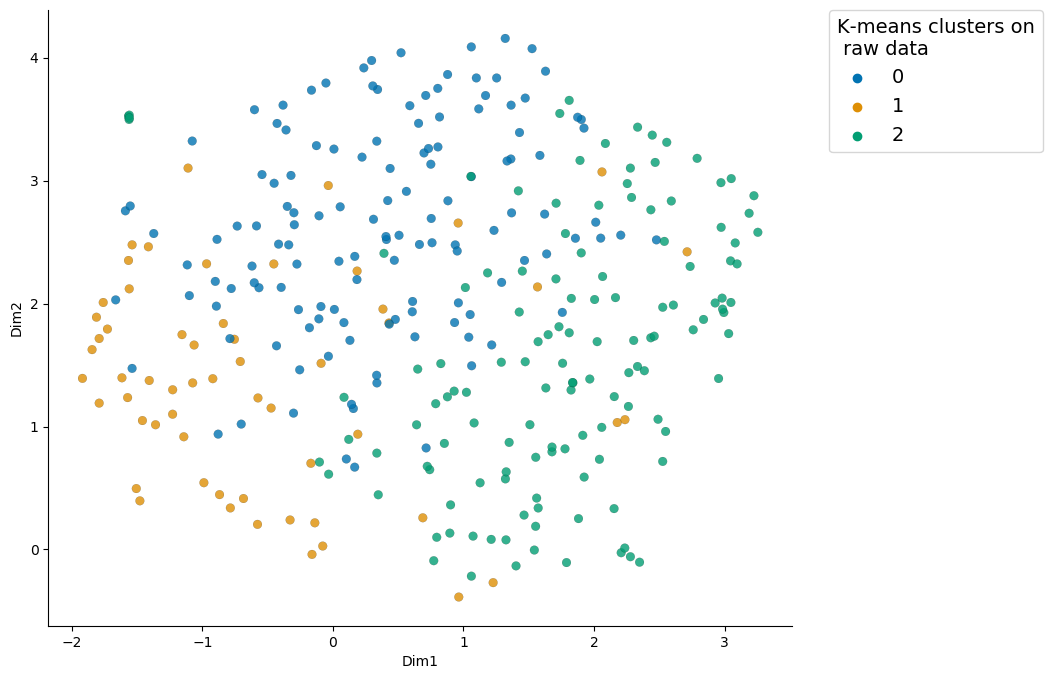

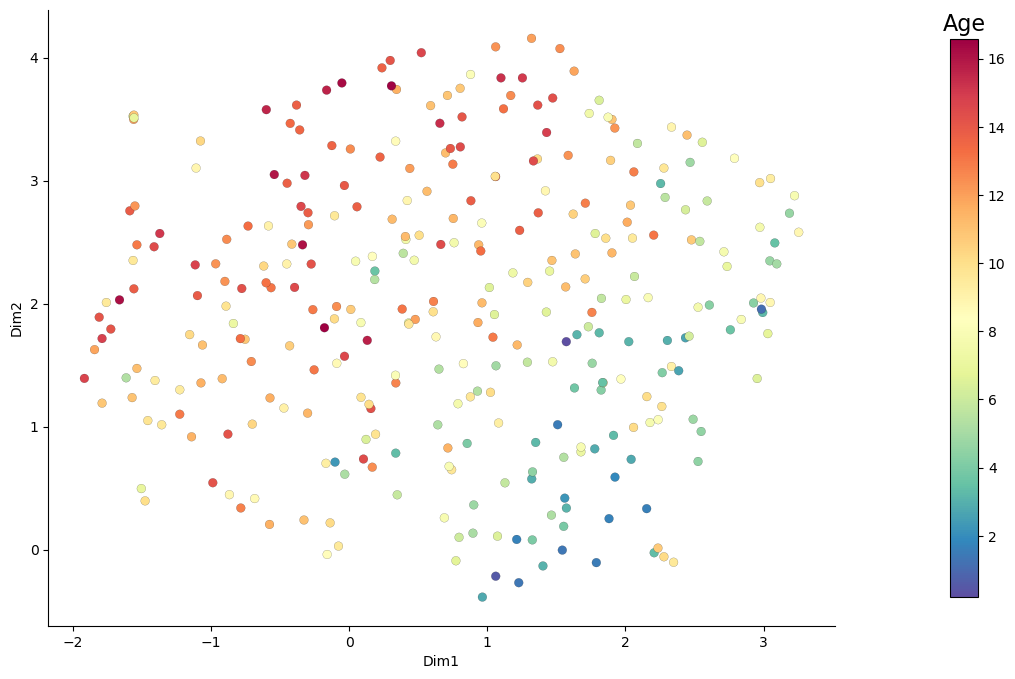

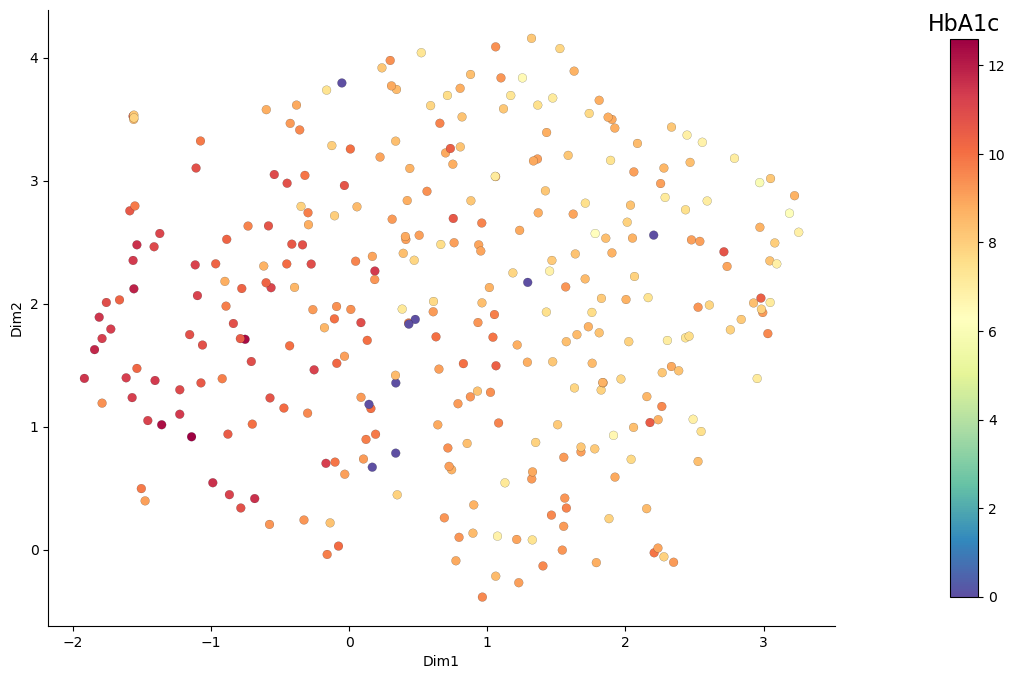

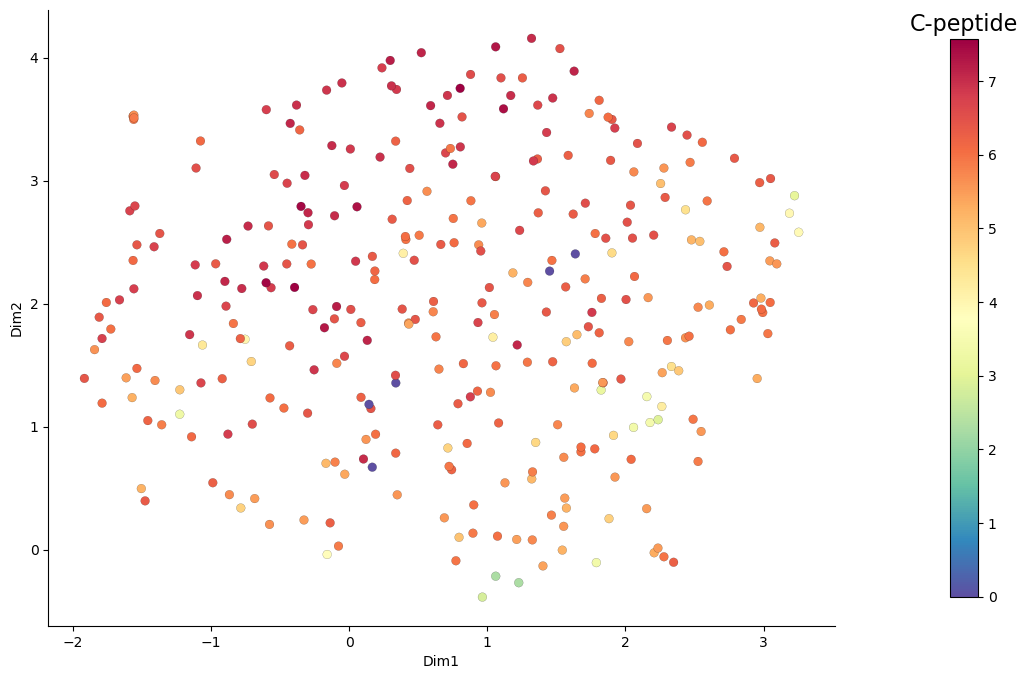

In [20]:
all = np.concatenate((train_loader.dataset.cat_all, train_loader.dataset.con_all), axis=1)

kmeans_raw = KMeans(n_clusters=3)
# Fitting the input data
kmeans_raw = kmeans_raw.fit(all)
# Getting the cluster labels
labels_raw = kmeans_raw.predict(all)
labels_raw = labels_raw.astype(str)
# Centroid values
centroids = kmeans_raw.cluster_centers_

reducer = umap.UMAP()
embedding_raw = reducer.fit_transform(all)

embedding_plot_discrete(embedding_raw, labels_raw, "K-means clusters on\n raw data", path + "/output/clustering/umap_raw_all.png")
embedding_plot_float(embedding_raw, age[mask], "Age", path + "/output/clustering/umap_raw_age.png")
embedding_plot_float(embedding_raw, HbA1c[mask], "HbA1c", path + "/output/clustering/umap_raw_hba1c.png")
embedding_plot_float(embedding_raw, Cpep[mask], "C-peptide", path + "/output/clustering/umap_raw_cpep.png")
